
MODEL EVALUATION SUMMARY:
-------------------------

1. CROSS-VALIDATION METRIC: RMSE
---------------------------
LinearRegression() RMSE:  18.7558
GradientBoostingRegressor(max_depth=7, n_estimators=40) RMSE:  17.6704

2. BEST MODEL:  GradientBoostingRegressor(max_depth=7, n_estimators=40)
------------

3. RMSE OF BEST MODEL:  17.6704
---------------------


Feature Importances:
                      importance
feature                        
grp_avg                0.686717
yearsExperience        0.152268
milesFromMetropolis    0.104738
grp_min                0.013758
grp_std                0.013266
grp_max                0.011813
grp_med                0.010126
jobType                0.004487
industry               0.001586
major                  0.000703
degree                 0.000535
companyId              0.000003
--------------------


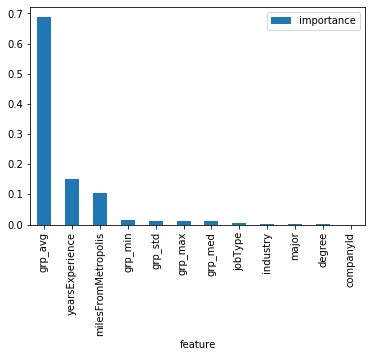

In [7]:
#!/usr/bin/env python3

# This script reads salary data, builds and tests predictive model,
# and then makes salary predictions on test data

# Python libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

#your info here
__author__ = "adebelen"
__email__ = "almadebelenece@gmail.com"
__references_ = "Data Science Dream Job"

# This class prepares the train and test dataframes
class DataPrep:
    
    # initialize the class variables 
    def __init__(self, train_file, trgt_file, test_file, catg_colms, numr_colms, trgt_colm, id_colm):
        self.catg_colms = list(catg_colms)
        self.numr_colms = list(numr_colms)
        self.ftures_colms = catg_colms + numr_colms
        self.trgt_colm = trgt_colm
        self.id_colm = id_colm
        self.train_df = self.create_train_df()
        self.test_df = self.create_test_df()
        self.labels = self.create_dictionary()
        
    
    # this method creates the train_df dataframe accessible outside this class
    def create_train_df(self):
        df_train = self.prep_train(train_file, trgt_file, trgt_colm) 
        train_df = self.custom_labels(df_train)
        return train_df
    
    # this method creates the test_df dataframe that is accessible by other classes
    def create_test_df(self):
        tst_df = self.read_file(test_file)
        tst_df = self.clean_file(tst_df)
        test_df = self.custom_labels(tst_df)
        #test_df = test_df[self.ftures_colms]
        return test_df
    
    # this method replaces all values in the train_df and test_df with the labels    
    def custom_labels(self, df):
        labels = self.create_dictionary()
        df = df.replace(labels)
        return df
    
    # this method maps the custom labels to each group in the categorical features    
    # the method maps the groups in "milesFromMetropolis" feature with values based on negative correlation
    # "yearsExperience" features does not require label encoding 
    def create_dictionary(self):
        df = self.prep_train(train_file, trgt_file, trgt_colm) 
        mdf = self.custom_scale(catg_colms, trgt_colm)
        label1 = dict(zip(df['companyId'], mdf['mCompID']))
        label2 = dict(zip(df['jobType'], mdf['mjType']))
        label3 = dict(zip(df['degree'], mdf['mDegree']))
        label4 = dict(zip(df['major'], mdf['mMajor']))
        label5 = dict(zip(df['industry'], mdf['mIndustry']))
        #label6 = dict(zip(np.arange(100).tolist(), np.arange(100,0,-1).tolist()))
        labels = {"companyId":label1, "jobType":label2, "degree":label3, "major":label4, "industry":label5} 
        #"milesFromMetropolis":label6}
        return labels
       
    # this method creates a new dataframe with categorical features, computes their means, uses LabelEncoder 
    # to transform the means, create new labels that sorted based on means (not alphabetically)    
    def custom_scale(self, catg, trgt):
        df_train = self.prep_train(train_file, trgt_file, trgt_colm)   
        mean_df = pd.DataFrame(df_train[catg + [trgt]])
        renm_colms = ['mCompID','mjType','mDegree','mMajor', 'mIndustry', 'salary']
        mean_df.columns = renm_colms
        for i in range(0, len(renm_colms)-1):
            mean_df[renm_colms[i]] = mean_df.groupby(mean_df[renm_colms[i]])[trgt_colm].transform('mean') 
            mean_df[renm_colms[i]] = le.fit_transform(mean_df[renm_colms[i]])
        return mean_df
   
    # this method creates the train_df for customised label encoding   
    def prep_train(self, file1, file2, trgt_colm):
        df_trn = self.read_file(train_file)
        df_trgt = self.read_file(trgt_file)
        df_trn_trgt = self.merge_files(df_trn, df_trgt, key=id_colm)
        df_train = self.clean_file(df_trn_trgt)
        df_train = df_train[df_train[trgt_colm]>0]
        return df_train
    
    # this method drops duplicate rows
    # add other "cleanse" codes - dropna, fillna, etc.
    def clean_file(self, df):
        df = df.drop_duplicates(subset=id_colm)
        return df
    
    # this method merges two dataframes (features and target dfs)
    def merge_files(self, file1, file2, key=None):
        return pd.merge(left=file1, right=file2, how='inner', on=key)
    
    # this method reads the given csv files
    def read_file(self, file):
        return pd.read_csv(file) 

# This class adds new features
class FeatureEngineering:
    
    def __init__(self, dp):   
        self.dp = dp   
        self.groups = dp.train_df.groupby(dp.catg_colms)
        self.new_ftures_df = self.create_new_ftures_df()
        self.dp.train_df = self.create_new_train_df()
        self.dp.test_df = self.create_new_test_df()
        self.update_ftures_colms(self.dp, new_ftures_colms=self.new_ftures_df.columns.to_list())
        
    # this method creates a train_df file with new features and overwrites dp.train_df
    def create_new_train_df(self):
        #self.new_ftures_df = self.create_new_ftures_df()
        self.dp.train_df = self.merge_new_dfs(dp.train_df, self.new_ftures_df, dp.catg_colms, fillna=True)
        return dp.train_df
    
    # this method creates a test_df file with new features and overwrites dp.test_df
    def create_new_test_df(self):
        #self.new_ftures_df = self.create_new_ftures_df()
        self.dp.test_df = self.merge_new_dfs(dp.test_df, self.new_ftures_df, dp.catg_colms, fillna=True)
        return dp.test_df
    
    # this method creates the new features dataframe
    def create_new_ftures_df(self):
        trgt_colm = dp.trgt_colm
        new_ftures_df = pd.DataFrame({'grp_avg': self.groups[trgt_colm].mean()}) 
        new_ftures_df['grp_std'] = self.groups[trgt_colm].std()
        new_ftures_df['grp_min'] = self.groups[trgt_colm].min()
        new_ftures_df['grp_med'] = self.groups[trgt_colm].median()
        new_ftures_df['grp_max'] = self.groups[trgt_colm].max()
        return new_ftures_df
    
    # this method merges the new features df and and dp.train_df 
    # these dfs have different sizes and merging them will generate null values
    # this method imputes '0' on null values
    def merge_new_dfs(self, dptrain, newftures, keys, fillna=True):
        merged_dfs = pd.merge(dptrain, newftures, on=keys, how='left')
        if fillna:
            merged_dfs.fillna(0, inplace=True)
        return merged_dfs
    
    # this method updates the dp.ftures list to include new features 
    def update_ftures_colms(self, dp, new_ftures_colms=[]):
        dp.ftures_colms.extend(new_ftures_colms)

# This class creates the data model using GBR        
class DataModeling:
    
    # This method initialises the class variables
    def __init__(self, dp, dm=[]):
        self.df_to_scale = dp.train_df[dp.ftures_colms]
        self.trgt_colm = dp.train_df[trgt_colm]
        self.X_train, self.X_test, self.y_train, self.y_test = self.sca_ft_xform_splt_df(self.df_to_scale, self.trgt_colm)
        self.dm = dm
        self.mean_rmse = {}
        self.best_model = None
        self.predictions = None      
    
    # This method computes the negated mean squared error of the model
    def cross_validate(self, df, k=2, num_procs=2):
        for model in self.dm:
            neg_rmse = cross_val_score(model, self.X_train, self.y_train, cv=k, n_jobs=num_procs, 
                                  scoring='neg_root_mean_squared_error')
            self.mean_rmse[model] = -np.mean(neg_rmse)
            
    # This method adds models to the list of models to be evaluated
    def add_model(self, model):
        self.dm.append(model)
    
    # This method picks both the value and athe name of the model with the lowest mean rmse
    def best_rmse(self):
        self.best_model = min(self.mean_rmse, key=self.mean_rmse.get)
    
    # This method fits the model on the training dataset X_train, y_train
    def fit_best_model(self, ftures, trgt):
        self.best_model.fit(ftures, trgt)

    # This method predicts the target salaries on X_train, using the best model 
    def predict_target(self, ftures):    
        self.predictions = self.best_model.predict(ftures)
          
    # This method scales and fits dp.test_df (if needed) before predicting  
    def scale_test_df(self, df):
        salary_scaler.fit(df)
        scaled_test_df = salary_scaler.transform(df)
        return scaled_test_df

    # This method scales, fits, transforms, and splits the input dataframe (dp.train_df=df_to_scale)
    # into train  & test "x" files
    def sca_ft_xform_splt_df(self, df, trgt_colm):
        salary_scaler.fit(df)
        scaled_df = salary_scaler.transform(df)
        X_train, X_test, y_train, y_test = train_test_split(scaled_df, trgt_colm, test_size=.20, random_state=40)
        return X_train, X_test, y_train, y_test  
    
    # This method saves the predictions
    def save_results(self):
        np.savetxt('salary_predictions_rmse.csv', self.predictions, delimiter=',')
        
    # This method shows the feature importances
    def get_importances(self, model, features):
        importances = model.feature_importances_
        feature_importances = pd.DataFrame({'feature':features, 'importance':importances})
        feature_importances.sort_values(by='importance', ascending=False, inplace=True)
        #set index to 'feature'
        feature_importances.set_index('feature', inplace=True, drop=True)
        return feature_importances    
     
    # This method prints the summary of model training 
    def summ_eval(self):
        print('\nMODEL EVALUATION SUMMARY:')
        print('-------------------------')
        print('\n1. CROSS-VALIDATION METRIC: RMSE')
        print('---------------------------')
        for model in dm.mean_rmse:
            print(model, 'RMSE: ',round(dm.mean_rmse[model],4))
        print('\n2. BEST MODEL: ',dm.best_model)
        print('------------')
        print('\n3. RMSE OF BEST MODEL: ',round(dm.mean_rmse[dm.best_model],4))
        print('---------------------')
        print()        
        print('\nFeature Importances:\n', dm.get_importances(dm.best_model, dp.ftures_colms))
        print('--------------------')
        feature_importances = self.get_importances(dm.best_model, dp.ftures_colms)
        feature_importances.plot.bar()
        plt.show()     

if __name__ == '__main__':
    
    # given data 
    train_file = ('train_features.csv')
    trgt_file = ('train_salaries.csv')
    test_file = ('test_features.csv')
    
    # dataprep class variables
    catg_colms = ['companyId','jobType','degree','major','industry']
    numr_colms = ['yearsExperience','milesFromMetropolis']
    trgt_colm = 'salary'
    id_colm = 'jobId'

    # create object for DataPrep class and store the variabeles to it)
    le = preprocessing.LabelEncoder()
    dp = DataPrep(train_file, trgt_file, test_file, catg_colms, numr_colms, trgt_colm, id_colm)
    
    # declare the scaler and the model initialize the model
    num_procs=2
    verbose_lvl = 0
    salary_scaler = StandardScaler()
    
    # feature engineering new features
    new_features = True
    # New Features:
    if new_features:
        fe = FeatureEngineering(dp)
        
    # data modeling 
    dm = DataModeling(dp)
    
    # Hyperparameter has been pre-tuned
    dm.add_model(LinearRegression())
    dm.add_model(GradientBoostingRegressor(n_estimators=40, max_depth=7, loss='ls', verbose=verbose_lvl))
    
    # run the functions on the train_df to:
    dm.cross_validate(dp, k=2, num_procs=num_procs)
    dm.best_rmse()
    dm.fit_best_model(dm.X_train, dm.y_train)
    #dm.predict_target(dm.X_test)
    dm.predict_target(dp.test_df[dp.ftures_colms])
       
    # print the training evaluation and test summary:
    dm.summ_eval()
    
    # apply the prediction code on dp.test_df
     #dm.save_results()